In [1]:
!pip install pycountry


In [2]:


import numpy as np
import pycountry
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from heapq import heappop, heappush, heapify

In [3]:
class Team:
    def __init__(self, country_id, country_name, skill):
        # Constructor method to initialize object attributes
        self.country_id = country_id
        self.country_name = country_name  # Set the country name
        self.skill = skill  # Set the skill level from 1 to 10

    def __str__(self):
        # String representation method to provide a formatted output
        return f"Country_ID: {self.country_id}, Country: {self.country_name}, Skill: {self.skill}/10"

class Person:
    def __init__(self, person_id, country_id, ratings, segment, country_names):
        self.identifier = person_id
        self.country_id = country_id
        self.country_name = country_names[country_id]
        self.ratings = ratings
        self.segment = segment # integer 1 to 9;
        self.has_ticket =  False
        self.preferences = []
        self.ratings[country_id] = 10

    def ticket_given(self):
        self.has_ticket = True

    def generate_preferences(self, game_schools_dict):
        # first order by games, namely rank_team_1 + rank_team_2
        # then, order by ticket price category
        game_rank_dict = {}
        for game in game_schools_dict.keys():
            game_rank_dict[game] = self.ratings[game.team1.country_id] + self.ratings[game.team2.country_id]
        sorted_games = sorted(game_rank_dict, key=game_rank_dict.get, reverse=True)

        if self.segment == 1: # high only
            self.preferences = [game_schools_dict[game][2].school_id for game in sorted_games]
        elif self.segment == 2: # medium only
            self.preferences = [game_schools_dict[game][1].school_id for game in sorted_games]
        elif self.segment == 3: # low only
            self.preferences = [game_schools_dict[game][0].school_id for game in sorted_games]
        elif self.segment == 4: # high over medium
            for game in sorted_games:
                self.preferences.append(game_schools_dict[game][2].school_id)
                self.preferences.append(game_schools_dict[game][1].school_id)
        elif self.segment == 5: # medium over high
            for game in sorted_games:
                self.preferences.append(game_schools_dict[game][1].school_id)
                self.preferences.append(game_schools_dict[game][2].school_id)
        elif self.segment == 6: # medium over low
            for game in sorted_games:
                self.preferences.append(game_schools_dict[game][1].school_id)
                self.preferences.append(game_schools_dict[game][0].school_id)
        elif self.segment == 7: # low over medium
            for game in sorted_games:
                self.preferences.append(game_schools_dict[game][0].school_id)
                self.preferences.append(game_schools_dict[game][1].school_id)
        elif self.segment == 8: # low over medium over high
            for game in sorted_games:
                self.preferences.append(game_schools_dict[game][0].school_id)
                self.preferences.append(game_schools_dict[game][1].school_id)
                self.preferences.append(game_schools_dict[game][2].school_id)
        elif self.segment == 9: # high over medium over low
            for game in sorted_games:
                self.preferences.append(game_schools_dict[game][2].school_id)
                self.preferences.append(game_schools_dict[game][1].school_id)
                self.preferences.append(game_schools_dict[game][0].school_id)

    def __str__(self):
        return f"Person_ID: {self.identifier}, Country_ID: {self.country_id}, Country: {self.country_name}, Segment: {self.segment}"


class game():
    def __init__(self, game_id, team1, team2):
        self.game_id = game_id
        self.team1 = team1
        self.team2 = team2
        self.outcome = 0

    def __str__(self):
        return f"{self.team1.country_name} vs {self.team2.country_name}"


class grup_stage_games():
    def __init__(self, teams):
        self.teams = teams
        self.groups = []
        self.games =[]
        self.generate_groups()
        self.generate_games()

    def generate_groups(self):
        n = len(self.teams)
        self.groups = []
        group_i = []
        for i in range(1, n+1):
            group_i.append(self.teams[i-1])
            if i % 4 == 0 and i != 0:
                self.groups.append(group_i)
                group_i = []

    def generate_games(self):
        self.games = []
        game_id = 0
        for group in self.groups:
            for i in range(len(group) - 1):
                for j in range(i + 1, len(group)):
                    self.games.append(game(game_id, group[i], group[j]))
                    game_id += 1


    def __str__(self):
        return f"Groups: {self.groups}, Games: {self.games}"


class school():
    def __init__(self, school_id, game, category, people, capacity = 50, percent = 0):
        self.school_id = school_id
        self.game = game
        self.category = category
        self.capacity = capacity
        self.segments = set()
        self.people = people
        self.percent = percent # percent of people prioritizes over the rest based on origin
        self.priorities = []
        self.set_segments()
        self.generate_priorities()

    def set_segments(self):
        if self.category == "high":
            self.segments = {1, 4, 5, 8}
        elif self.category == "medium":
            self.segments = {2, 4, 5, 6, 7, 8}
        elif self.category == "low":
            self.segments = {3, 6, 7, 8}
        else:
            TypeError("Invalid category")

    def generate_priorities(self):
        shuffled = self.people.copy()
        np.random.shuffle(shuffled)
        num_county1 = self.percent * self.capacity
        num_county2 = self.percent * self.capacity
        prioritized = []
        for pers in shuffled:
            if pers.segment in self.segments:
                if num_county1 > 0 and pers.country_id == self.game.team1.country_id:
                    prioritized.append(pers)
                    num_county1 -= 1
                    continue
                if num_county2 > 0 and pers.country_id == self.game.team2.country_id:
                    prioritized.append(pers)
                    num_county2 -= 1
                    continue
                self.priorities.append(pers)

        for i in prioritized:
            self.priorities.insert(0, i)

    def __str__(self):
        return f"School_ID: {self.school_id}, Game: {self.game}, Category: {self.category}, Capacity: {self.capacity}, Percent: {self.percent}"

def rpsrd(people, game_schools_dict, truncate, school_id_to_school):
    "random priority serial random dictator"
    mu_people = {}  # pers_id to school_id
    mu_schools = {school_id: set() for school_id in school_id_to_school.keys()}  # school_id to set of pers_ids
    free_people = set(people)  # Start with all people free
    proposals = {person.identifier: 0 for person in people}  # Track the index of the next school to propose to

    while free_people:
        # Shuffle the list of people
        free_people = list(free_people)
        np.random.shuffle(list(free_people))
        # Iterate over the shuffled list of people
        for person in free_people:
            person_preferences = person.preferences[:truncate]
            np.random.shuffle(person_preferences)
            for school_id in person_preferences:
                proposed_school = school_id_to_school[school_id]
                if len(mu_schools[school_id]) < proposed_school.capacity:
                    mu_schools[school_id].add(person.identifier)
                    mu_people[person.identifier] = school_id
                    free_people.remove(person)
                    break
        return mu_people, mu_schools

def school_choice(people, game_schools_dict, truncate, school_id_to_school):
    mu_people = {}  # pers_id to school_id
    mu_schools = {school_id: set() for school_id in school_id_to_school.keys()}  # school_id to set of pers_ids
    free_people = set(people)  # Start with all people free
    proposals = {person.identifier: 0 for person in people}  # Track the index of the next school to propose to

    round = 1
    while free_people:
        round += 1

        for person in list(free_people):
            person_preferences = person.preferences[:truncate]
            if proposals[person.identifier] < len(person_preferences):
                # Get the next school to propose to
                next_school_id = person_preferences[proposals[person.identifier]]
                proposed_school = school_id_to_school[next_school_id]
                proposals[person.identifier] += 1

                # Add person to the school's list temporarily
                if len(mu_schools[next_school_id]) < proposed_school.capacity:
                    mu_schools[next_school_id].add(person.identifier)
                    mu_people[person.identifier] = next_school_id
                    free_people.remove(person)
                else:
                    # Need to reject someone if over capacity
                    # Find the least preferred person in the current set
                    current_members = list(mu_schools[next_school_id])

                    current_members_sorted = sorted(current_members, key=lambda x: proposed_school.people.index(people[x]))
                    least_preferred_id = current_members_sorted[-1] # pers id
                    least_preferred = people[least_preferred_id]

                    if proposed_school.people.index(person) < proposed_school.people.index(least_preferred):
                        # Swap out the least preferred for the new person
                        mu_schools[next_school_id].remove(least_preferred_id)
                        mu_schools[next_school_id].add(person.identifier)
                        mu_people[person.identifier] = next_school_id
                        mu_people.pop(least_preferred, None)
                        free_people.add(least_preferred)  # Add back the rejected person to free list
                    else:
                        # Current person gets rejected
                        if proposals[person.identifier] >= len(person_preferences):
                            free_people.remove(person)
            else:
                # No more schools to propose to, remove from free people
                free_people.remove(person)

    return mu_people, mu_schools


In [32]:
def generate_environment(num_countries, num_people, capacity):
    country_names = {}

    # Get all country names
    all_country_names = [country.name for country in pycountry.countries]

    n = num_countries  # Number of random country names participating
    country_names = random.sample(all_country_names, n)  # Randomly select n country names

    # Create a list of Team objects
    teams = [Team(country_id = i, country_name = country_names[i], skill=random.randint(1, 10)) for i in range(n)]

    country_id_to_country_name = {team.country_id: team.country_name for team in teams}

    # Create a list of Person objects
    people = [Person(i, random.randint(0, n-1), np.random.uniform(1, 10, size=n), random.randint(1, 7), country_names) for i in range(num_people)]

    group_stg_games_obj = grup_stage_games(teams)


    game_schools_dict = {} # dict mapping a game to a list of corresponding schools [low, medium, high]
    school_id = 0
    school_id_to_school = {}

    for game in group_stg_games_obj.games:
        game_low = school(school_id, game, "low", people, capacity)
        game_medium = school(school_id + 1, game, "medium", people, capacity)
        game_high = school(school_id + 2, game, "high", people, capacity)

        school_id_to_school[school_id] = game_low
        school_id_to_school[school_id + 1] = game_medium
        school_id_to_school[school_id + 2] = game_high
        school_id += 3

        game_schools_dict[game] = [game_low, game_medium, game_high]

    for person in people:
        person.generate_preferences(game_schools_dict)


    return people, game_schools_dict, school_id_to_school


def analysis(mu_people, people, mu_schools, school_id_to_school):
    preference_index = {} # which ticket did a person get?
    # Analysis
    for person_id in mu_people.keys():
        school_id = mu_people[person_id]
        order = people[person_id].preferences.index(school_id)
        if order in preference_index.keys():
            preference_index[order] += 1
        else:
            preference_index[order] = 1
    return preference_index

def vizualize(preference_index):
    # Create a DataFrame from the dictionary
    df = pd.DataFrame(list(preference_index.items()), columns=['Preference', 'Number of People'])

    # Calculate the total number of people to normalize data
    total_people = df['Number of People'].sum()
    df['Normalized'] = df['Number of People'] / total_people

    # Set up the figure size
    plt.figure(figsize=(12, 6))

    # Create a bar plot for normalized data
    sns.barplot(x='Preference', y='Normalized', data=df)

    # Set plot title and labels
    plt.title('Proportion of People Receiving Each Preference')
    plt.xlabel('Preference Index')
    plt.ylabel('Proportion of People')

    # Display the plot
    plt.show()

# Truncate at 4 preferences

In [38]:
truncate = 4
num_countries = 16
num_people = 400*num_countries
capacity = 40

preferences_rpsrd = {}
preferences_school_choice = {}

for experiment in range(5):
    print("Experiment: ", experiment + 1, "out of 5")
    people, game_schools_dict, school_id_to_school = generate_environment(num_countries, num_people, capacity)
    mu_people, mu_schools = school_choice(people, game_schools_dict, truncate, school_id_to_school)
    preference_index = analysis(mu_people, people, mu_schools, school_id_to_school)
    for key, value in preference_index.items():
        if key in preferences_school_choice.keys():
            preferences_school_choice[key] += value
        else:
            preferences_school_choice[key] = value

    mu_people, mu_schools = rpsrd(people, game_schools_dict, truncate, school_id_to_school)
    preference_index = analysis(mu_people, people, mu_schools, school_id_to_school)

    for key, value in preference_index.items():
        if key in preferences_rpsrd.keys():
            preferences_rpsrd[key] += value
        else:
            preferences_rpsrd[key] = value

Experiment:  1 out of 5
Experiment:  2 out of 5
Experiment:  3 out of 5
Experiment:  4 out of 5
Experiment:  5 out of 5


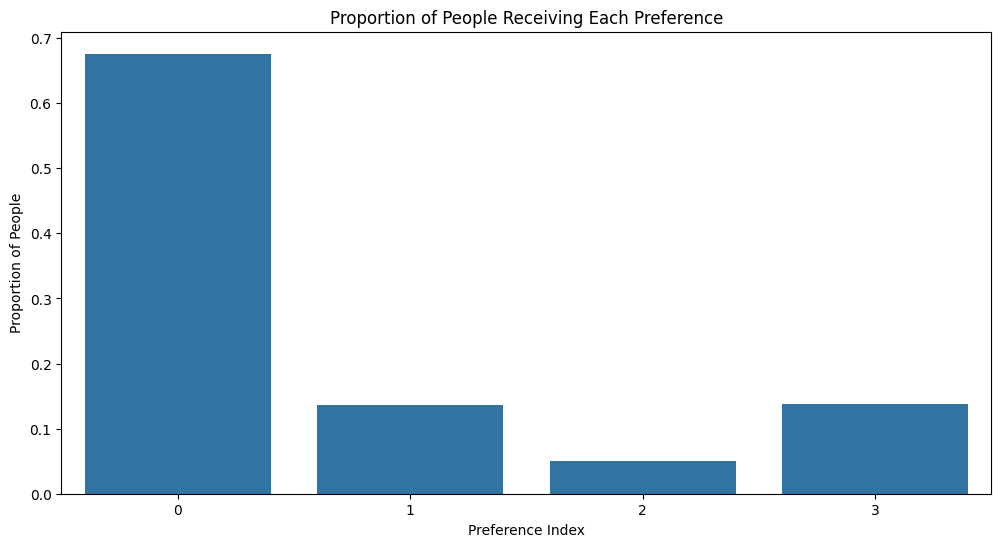

In [39]:
vizualize(preferences_school_choice)

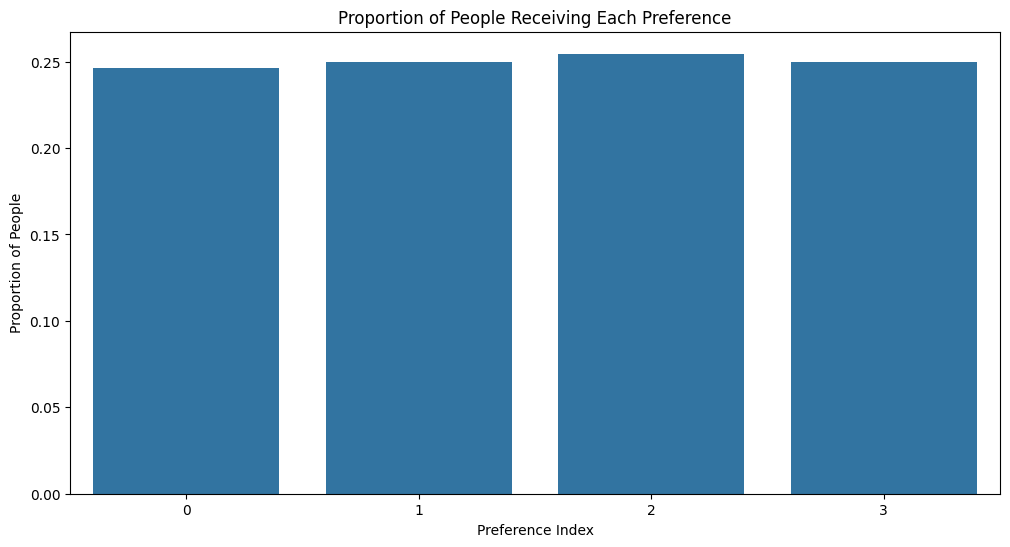

In [40]:
vizualize(preferences_rpsrd)

# Truncate at 8 preferences

In [22]:
truncate = 8
num_countries = 16
num_people = 400*num_countries
capacity = 30

preferences_rpsrd10 = {}
preferences_school_choice10 = {}

for experiment in range(5):
    print("Experiment: ", experiment+1, "out of 5")
    people, game_schools_dict, school_id_to_school = generate_environment(num_countries, num_people, capacity)
    mu_people, mu_schools = school_choice(people, game_schools_dict, truncate, school_id_to_school)
    preference_index = analysis(mu_people, people, mu_schools, school_id_to_school)
    for key, value in preference_index.items():
        if key in preferences_school_choice.keys():
            preferences_school_choice[key] += value
        else:
            preferences_school_choice[key] = value

    mu_people, mu_schools = rpsrd(people, game_schools_dict, truncate, school_id_to_school)
    preference_index = analysis(mu_people, people, mu_schools, school_id_to_school)

    for key, value in preference_index.items():
        if key in preferences_rpsrd.keys():
            preferences_rpsrd[key] += value
        else:
            preferences_rpsrd[key] = value

Experiment:  1 out of 5
Experiment:  2 out of 5
Experiment:  3 out of 5
Experiment:  4 out of 5
Experiment:  5 out of 5


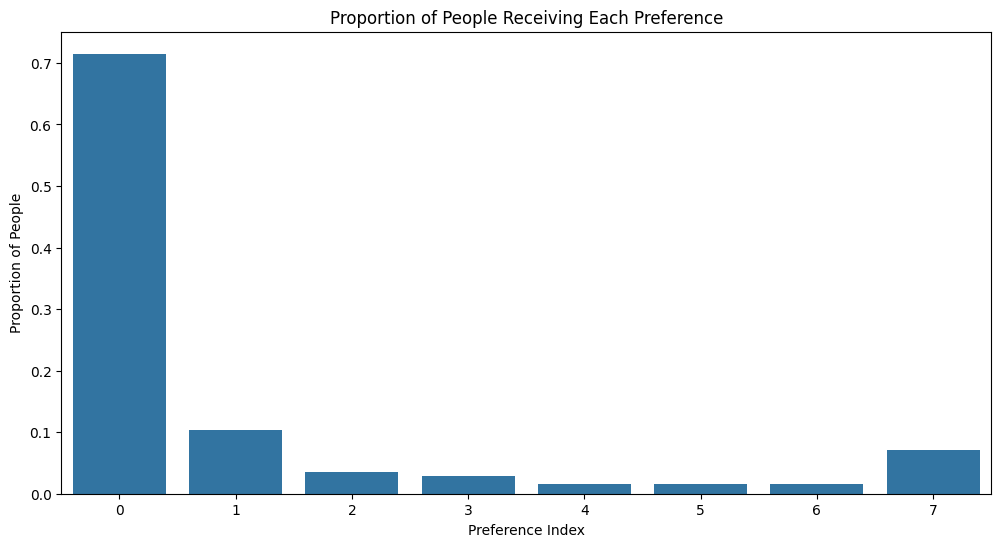

In [31]:
vizualize(preferences_school_choice10)

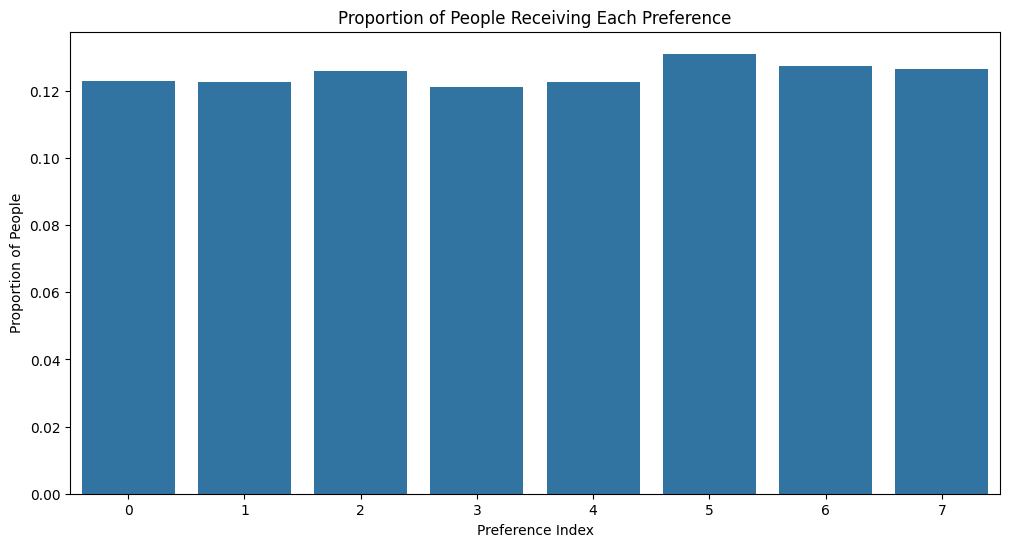

In [30]:
vizualize(preferences_rpsrd10)